# Preliminary Analysis

This section will serve as the preliminary analysis of the dataset that I'm using for this project.

Goals for this section:

1. Load the data into collab
2. Analyze the distribution of variables
3. Visualize base level correlations


## Loading the Data

Hopefully this works on the first try, considering it's a pretty hefty chunk of data.

In [1]:
import lightgbm as lgb
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from google.colab import drive  
from lightgbm.sklearn import LGBMClassifier
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount("/content/gdrive")  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/CISC 372/Project/ks-projects-201801.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB
None


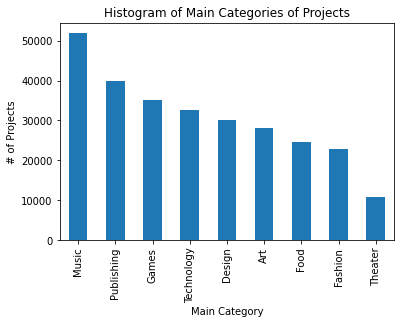

In [4]:
print(data.info())
plot = data["main_category"].value_counts()[1:10].plot.bar()
plot.set_xlabel("Main Category")
plot.set_ylabel("# of Projects")
plot.set_title("Histogram of Main Categories of Projects")
fig = plot.get_figure()
# parameter to make sure labels of figure aren't cut off
fig.savefig("fig.png",bbox_inches = "tight")

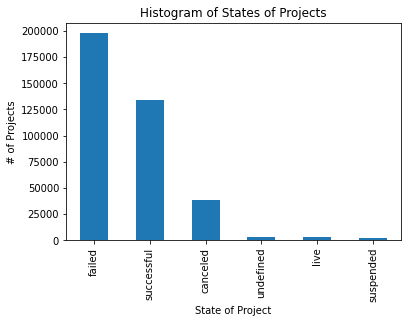

In [5]:
# Let's get an idea as to the distribution of different outcomes
plot = data["state"].value_counts().plot.bar()
plot.set_xlabel("State of Project")
plot.set_ylabel("# of Projects")
plot.set_title("Histogram of States of Projects")
fig = plot.get_figure()
# parameter to make sure labels of figure aren't cut off
fig.savefig("test.png",bbox_inches = "tight")

## Let's Build A Simple Model

Based on some of the basic understanding I have of the data, I'm going to build a simple LGBM model to see if we can effectively predict how well the model is going to perform. 

In [0]:
# First, let's save the categorical features
data.head()
categorical_features = ["category", "main_category", "country"]

numeric_features = ["usd_goal_real", "backers"]

categorical_transformer = Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

numeric_transformer = Pipeline(steps=[
                ("imputer", SimpleImputer(fill_value="median")),
                ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
          ("num", numeric_transformer, numeric_features),
          ("cat", categorical_transformer, categorical_features)
    ]
)

In [0]:
# Let's make the target attribute a bit prettier, and split the data into train/test
# Drop live projects
data = data.query('state != "live" and state != "undefined"')

# Add outcome column, "successful" == 1, others are 0
data = data.assign(outcome=(data['state'] == 'successful').astype(int))

In [0]:
# data = data.drop(["state", "ID", "name", "currency", "deadline", "goal", "launched","pledged", "usd pledged"], axis=1)

y = data.outcome
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3)

# Select features from sets to be used
X_train = X_train[[*numeric_features, *categorical_features]]
X_test = X_test[[*numeric_features, *categorical_features]]

In [9]:
# Build classification pipeline for LightGBM
regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LGBMClassifier(boosting_type='gbdt',
                        objective='binary'
                      ))])


# Select features from sets to be used
# X_test.drop(["outcome"], axis=1)

# `__` denotes attribute 
# (e.g. regressor__n_estimators means the `n_estimators` param for `regressor`
#  which is our xgb).
param_grid = {
    'preprocessor__num__imputer__strategy': ['median'],
    'regressor__num_leaves': [30, 45],
    'regressor__n_estimators': [200, 300],
    'regressor__max_depth': [10, 15],
    'regressor__learning_rate': [0.03, 0.05],
    'regressor__min_data_in_leaf' : [10, 20],
}

# Grid search the parameters above, 3-fold cv
grid_search = GridSearchCV(
    regr, param_grid, cv=3, verbose=3, n_jobs=1, 
    scoring='accuracy')

# Parameter optimization and model fitting
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] preprocessor__num__imputer__strategy=median, regressor__learning_rate=0.03, regressor__max_depth=10, regressor__min_data_in_leaf=10, regressor__n_estimators=200, regressor__num_leaves=30 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  preprocessor__num__imputer__strategy=median, regressor__learning_rate=0.03, regressor__max_depth=10, regressor__min_data_in_leaf=10, regressor__n_estimators=200, regressor__num_leaves=30, score=0.935, total=   2.7s
[CV] preprocessor__num__imputer__strategy=median, regressor__learning_rate=0.03, regressor__max_depth=10, regressor__min_data_in_leaf=10, regressor__n_estimators=200, regressor__num_leaves=30 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  preprocessor__num__imputer__strategy=median, regressor__learning_rate=0.03, regressor__max_depth=10, regressor__min_data_in_leaf=10, regressor__n_estimators=200, regressor__num_leaves=30, score=0.936, total=   2.6s
[CV] preprocessor__num__imputer__strategy=median, regressor__learning_rate=0.03, regressor__max_depth=10, regressor__min_data_in_leaf=10, regressor__n_estimators=200, regressor__num_leaves=30 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV]  preprocessor__num__imputer__strategy=median, regressor__learning_rate=0.03, regressor__max_depth=10, regressor__min_data_in_leaf=10, regressor__n_estimators=200, regressor__num_leaves=30, score=0.934, total=   2.5s
[CV] preprocessor__num__imputer__strategy=median, regressor__learning_rate=0.03, regressor__max_depth=10, regressor__min_data_in_leaf=10, regressor__n_estimators=200, regressor__num_leaves=45 
[CV]  preprocessor__num__imputer__strategy=median, regressor__learning_rate=0.03, regressor__max_depth=10, regressor__min_data_in_leaf=10, regressor__n_estimators=200, regressor__num_leaves=45, score=0.935, total=   2.7s
[CV] preprocessor__num__imputer__strategy=median, regressor__learning_rate=0.03, regressor__max_depth=10, regressor__min_data_in_leaf=10, regressor__n_estimators=200, regressor__num_leaves=45 
[CV]  preprocessor__num__imputer__strategy=median, regressor__learning_rate=0.03, regressor__max_depth=10, regressor__min_data_in_leaf=10, regressor__n_estimators=200, regr

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  5.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [10]:
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)*100

93.43271555197421

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[67537,  4028],
       [ 3307, 36818]])